# Tutorial on using the classes for transpiling DBQA strategies into various types of double-bracket rotations (DBRs)

## 1. VQE results are loaded
## 2. The GC3 DBR is shown using explicit circuits obtained from more basic and special purpose functions
## 3. The same is done using the `GroupCommutatorIterationWithEvolutionOracles` class
### 3.1. It is shown how to perform more steps of the GCI. 
Using the class approach one can just change `mode_double_bracket_rotation=DoubleBracketRotationType.group_commutator_third_order_reduced` to a different type and same code will run.

In [1]:
import json
import time
from pathlib import Path

import numpy as np
import qibo
from qibo import hamiltonians, set_backend
from boostvqe.models.dbi.double_bracket import (
    DoubleBracketGeneratorType,
    DoubleBracketIteration,
)

from boostvqe.ansatze import VQE, build_circuit
from boostvqe.utils import apply_dbi_steps, rotate_h_with_vqe
from qibo import symbols, hamiltonians
from copy import deepcopy
from boostvqe.compiling_XXZ import *

import matplotlib.pyplot as plt

## 1. Loading VQE results

In [2]:

qibo.set_backend("numpy")

# set the path string which define the results
path = "../results/vqe_data/with_params/10q3l/sgd_10q_3l_42/"

# set the target epoch to which apply DBQA and the number of steps
target_epoch = 2000
dbi_steps = 1

# upload system configuration and parameters for all the training
with open(path + "optimization_results.json") as file:
    config = json.load(file)

losses = dict(np.load(path + "energies.npz"))["0"]
params = np.load(path + f"parameters/params_ite{target_epoch}.npy")

nqubits = config["nqubits"]
# build circuit, hamiltonian and VQE
hamiltonian = hamiltonians.XXZ(nqubits=nqubits, delta=0.5)
circuit = build_circuit(nqubits, config["nlayers"], "numpy")
vqe = VQE(circuit, hamiltonian)
zero_state = hamiltonian.backend.zero_state(nqubits)
zero_state_t = np.transpose([zero_state])
target_energy = np.min(hamiltonian.eigenvalues())


# set target parameters into the VQE
vqe.circuit.set_parameters(params)
vqe_state = vqe.circuit().state()

ene1 = hamiltonian.expectation(vqe_state)


[Qibo 0.2.9|INFO|2024-06-14 14:11:37]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0
[Qibo 0.2.9|INFO|2024-06-14 14:11:38]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0


In the VQE numpy


In [3]:
print(f"VQE energy is {ene1}. \n\
The target energy is {target_energy} which means the difference is {ene1-target_energy}.\n\
The relative difference is {round(abs(ene1-target_energy)/abs(target_energy)*100,2)}%.")

VQE energy is -14.560174594055583. 
The target energy is -15.276131122065795 which means the difference is 0.7159565280102118.
The relative difference is 4.69%.


# 2. Circuits by hand showing 1 GCI 3 step we want to compile
$D= \sum_i B_i Z_i$
and Group commutator

After boosting we have -14.7495 which is an improvement 0.1893 over VQE with -14.560174594055583. 
The target energy is -15.276131122065795 which means the difference after GCI is 0.5266.
The relative difference is 3.45%      and was 4.69%.


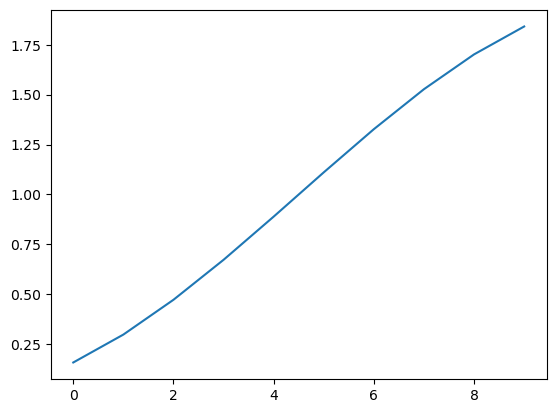

In [4]:
b_list = [1+np.sin(x) for x in np.linspace(-1,1,nqubits) ]
#b_list = np.random.rand(nqubits)
d = hamiltonians.SymbolicHamiltonian( sum([b*symbols.Z(j) for j,b in zip(range(nqubits),b_list)]))

step = 0.12
u2_circ = deepcopy(d).circuit( -step * (np.sqrt(5) - 1) / 2 ) 
u4_circ = deepcopy(d).circuit( step * (np.sqrt(5) + 1) / 2 )
u6_circ = deepcopy(d).circuit( -step  ) 

vqe_circ = vqe.circuit
vqe_circ_inv = vqe_circ.invert()
nmb_ts_steps = 1
u1_circ = vqe_circ +nqubit_XXZ_decomposition(nqubits=nqubits,t=-step * (np.sqrt(5) - 1) / 2,delta=0.5,steps=nmb_ts_steps, order = 2)+vqe_circ_inv 
u3_circ = vqe_circ +nqubit_XXZ_decomposition(nqubits=nqubits,t= step ,delta=0.5,steps=nmb_ts_steps, order = 2)+vqe_circ_inv 
u5_circ = vqe_circ +nqubit_XXZ_decomposition(nqubits=nqubits,t=-step * (3 - np.sqrt(5)) / 2,delta=0.5,steps=nmb_ts_steps, order = 2)+vqe_circ_inv 



circ_boost = (  u6_circ + u5_circ + u4_circ + u3_circ + u2_circ +vqe_circ )

ket_boost = circ_boost(initial_state=zero_state)
gci3_loss = hamiltonian.expectation(ket_boost.state()) 
print(f"After boosting we have {np.round(gci3_loss,4)} which is an improvement {np.round(ene1-gci3_loss,4)} over VQE with {ene1}. \n\
The target energy is {target_energy} which means the difference after GCI is {np.round(gci3_loss-target_energy,4)}.\n\
The relative difference is {np.round(abs(gci3_loss-target_energy)/abs(target_energy)*100,2)}%\
      and was {np.round(abs(ene1-target_energy)/abs(target_energy)*100,2)}%.")

plt.plot(b_list)

In [5]:
t=0
for g in circ_boost.queue:
    if isinstance(g, qibo.gates.gates.CNOT):
        t = t +1
print(f"The boosting circuit used {t} CNOT gates coming from compiled XXZ evolution.\n\
       For {nqubits} qubits this gives n_CNOT/n_qubits = {t/nqubits}")

The boosting circuit used 90 CNOT gates coming from compiled XXZ evolution.
       For 10 qubits this gives n_CNOT/n_qubits = 9.0


In [6]:
t=0
for g in circ_boost.queue:
    if isinstance(g, qibo.gates.gates.CZ):
        t = t +1
print(f"The boosting circuit used {t} CZ gates coming from repeated wrapping by the VQE unitary.\n\
       For {nqubits} qubits this gives n_CZ/n_qubits = {t/nqubits}")

The boosting circuit used 150 CZ gates coming from repeated wrapping by the VQE unitary.
       For 10 qubits this gives n_CZ/n_qubits = 15.0


In [7]:
t=0
for g in vqe.circuit.queue:
    if isinstance(g, qibo.gates.gates.CZ):
        t = t +1
t

30

# 3. How to use the transpiling code

In [8]:
step = 0.12

from boostvqe.models.dbi.group_commutator_iteration_transpiler import *
from boostvqe.models.dbi.double_bracket_evolution_oracles import *

# quick hack how to use the method function hamiltonians.XXZ to get a simulable oracle
hamiltonian.delta = 0.5
hamiltonian.dense = hamiltonian
eo_xxz = XXZ_EvolutionOracle(hamiltonian,mode_evolution_oracle=EvolutionOracleType.numerical, steps = 1, order = 2)
eo_xxz.mode_evolution_oracle=EvolutionOracleType.hamiltonian_simulation
#hack end

# prescribe nmb of steps, otherwise there will be casting to dense and searching for a step duration (this can later be avoided with @shangtai non-classical simulation PR)
eo_xxz.please_use_prescribed_nmb_ts_steps = 1

# implement the rotate by VQE on the level of circuits
fsoe  = FrameShiftedEvolutionOracle(eo_xxz, before_circuit=vqe.circuit.invert(), 
                after_circuit=vqe.circuit,name="shifting by vqe")

# init gci with the vqe-rotated hamiltonian
gci  = GroupCommutatorIterationWithEvolutionOracles(input_hamiltonian_evolution_oracle=fsoe, 
        mode_double_bracket_rotation=DoubleBracketRotationType.group_commutator_third_order_reduced)

# init the generator of the evolution,
#  this is quite simple - just pass a diagonal SymbolicHamiltonian 
# and because it will be commuting we can use the member function circuit for compiling
eo_d = EvolutionOracle(d,mode_evolution_oracle=EvolutionOracleType.hamiltonian_simulation,name = "D(linear)")
eo_d.please_use_prescribed_nmb_ts_steps = 1

# above we didn't gauge the time \approx e^{x^2 [D,H]} but gci approximates e^{-sW} so takes a square root
circ_boost = (  gci.group_commutator(step**2, eo_d)["forwards"] +vqe_circ )

hamiltonian.expectation(circ_boost().state()) 

TypeError: 'Hamiltonian' object cannot be interpreted as an integer

In [ ]:
#above the group_commutator just gives a circuit - we can propagte this forward by the equivalent
gci(step**2, eo_d)
circ_boost = gci.get_composed_circuit()

hamiltonian.expectation(circ_boost().state()) 

-14.749515449118626

In [ ]:
circ_boost = gci.get_composed_circuit()

hamiltonian.expectation(circ_boost().state()) 

-14.749515449118626

In [ ]:
def loss(circ,h):
    return h.expectation(circ().state()) 

In [ ]:
losses = []
times = np.linspace(0.1,0.3,310)
for s in times:
    losses.append(loss(gci.group_commutator(s, eo_d)["forwards"]+circ_boost,hamiltonian))

([<matplotlib.axis.XTick at 0x75e462859970>],
 [Text(16.666666666666664, 0, '16.67')])

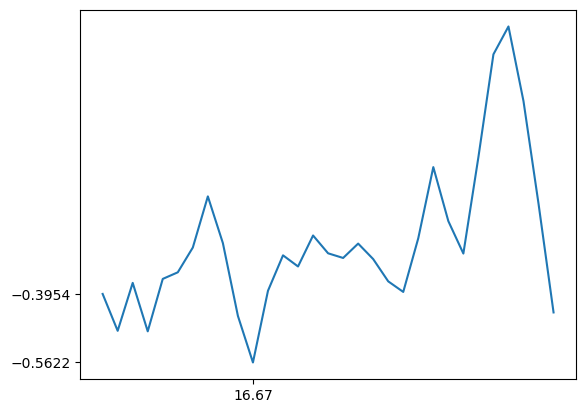

In [ ]:
plt.plot(times,losses)
plt.yticks([losses[0],losses[np.argmin(losses)]])
plt.xticks([times[np.argmin(losses)]])

In [ ]:
losses = []
times = np.linspace(10,30,31)
for s in times:
    losses.append(loss(gci.group_commutator(s, eo_d)["forwards"]+circ_boost,hamiltonian))
plt.plot(times,losses)
plt.yticks([losses[0],losses[np.argmin(losses)]])
plt.xticks([times[np.argmin(losses)]])

In [ ]:
gci(times[np.argmin(losses)], eo_d)
circ_boost = gci.iterated_hamiltonian_evolution_oracle.get_composed_circuit()

hamiltonian.expectation(circ_boost().state()) 

-14.81184144754536

In [ ]:
losses = []
times = np.linspace(0,0.03,10)
for s in times:
    losses.append(loss(gci.group_commutator(s, eo_d)["forwards"]+circ_boost,hamiltonian))

([<matplotlib.axis.XTick at 0x75e462858920>],
 [Text(0.006666666666666666, 0, '0.00667')])

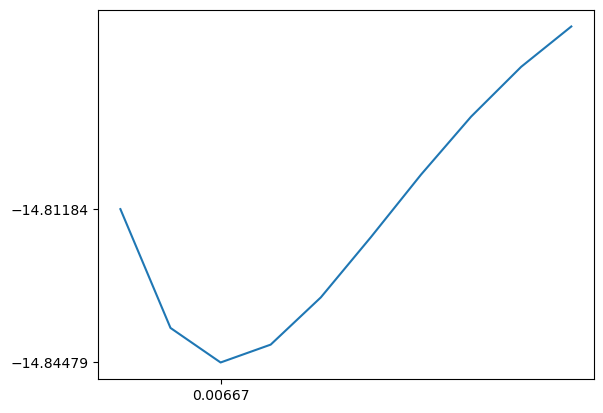

In [ ]:
plt.plot(times,losses)
plt.yticks([losses[0],losses[np.argmin(losses)]])
plt.xticks([times[np.argmin(losses)]])